In [1]:
from google.cloud import storage
import os
from io import StringIO, BytesIO
import numpy as np
from PIL import Image
import cv2
from matplotlib import pyplot as plt
from skimage.feature import graycomatrix, graycoprops
from sklearn.model_selection import train_test_split


In [2]:
client = storage.Client(project='AIPI540')
bucket = client.get_bucket('aipi540-cv')

In [125]:
from google.cloud import storage
import os
import pandas as pd

import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from torchvision import models, transforms
from skimage.segmentation import slic
from PIL import Image
import io
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL.Image import Resampling
import tifffile

In [74]:
# Load the pre-trained VGG model
vgg_model = models.vgg16(pretrained=False)
vgg_model.classifier[6] = nn.Sequential(
    nn.Linear(vgg_model.classifier[6].in_features, 512),
    nn.BatchNorm1d(512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512,3)
) 
vgg_model.load_state_dict(torch.load('vgg16_model.pth', map_location='cpu'))
vgg_model.eval()


/Users/choonghwanlee/Fundus-Imaging/env/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/choonghwanlee/Fundus-Imaging/env/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [75]:
vgg_model.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=3, bias=True)
  )
)

In [76]:
target_layers = [vgg_model.features[-1]]

cam = GradCAM(model=vgg_model, target_layers=target_layers)

In [77]:
def preprocess_image(image):
    transform = transforms.Compose([ 
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.3205, 0.2244,0.1613], std=[0.2996, 0.2158, 0.1711])])
    return transform(image)
    

In [96]:
input_tensor = preprocess_image(original_image_array).unsqueeze(0)

In [79]:
# Make prediction
with torch.no_grad():  # Disable gradient calculation for inference
    output = vgg_model(input_tensor)


In [83]:
probabilities = torch.nn.functional.softmax(output, dim=1)
_, predicted_class = torch.max(probabilities, 1)


In [108]:
heatmap = cam(input_tensor = input_tensor, targets = [ClassifierOutputTarget(1), ClassifierOutputTarget(2)])

In [130]:
def compute_iou(mask1: np.ndarray, mask2: np.ndarray) -> float:
    # Ensure the inputs are binary masks
    mask1 = mask1.astype(bool)
    mask2 = mask2.astype(bool)

    # Compute intersection and union
    intersection = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()

    # Handle edge case for empty union
    if union == 0:
        return 1.0 if intersection == 0 else 0.0

    return intersection / union

In [150]:
base_path = "segmentation/all_segmentation_groundtruths/"
original_images_path = "segmentation/original_images/"
dataset_sets = ["training_set", "testing_set"]

def list_files_in_gcs_directory(prefix):
    """List all files in a given GCS directory prefix."""
    blobs = client.list_blobs('aipi540-cv', prefix=prefix)
    return [blob.name for blob in blobs if not blob.name.endswith("/")]

def load_image_from_gcs(file_path):
    """Load an image from GCS and return as a numpy array."""
    blob = bucket.blob(file_path)
    img_data = blob.download_as_bytes()
    image = Image.open(io.BytesIO(img_data)).resize((224,224), resample= Resampling.NEAREST)
    return image


# Function to overlay segmentations into a single channel numpy array
def overlay_segmentations(image_id, set):
    # Initialize a blank numpy array to store all segmentations combined in the same channel
    combined_segmentation = np.zeros((224,224), dtype=np.uint8)  # Assuming each image is 224x224

    segmentation_types = ["haemorrhages", 'hard_exudates', 'microaneurysms', 'soft_exudates']
    segmentation_ext = ["HE", "EX", "MA", "SE"]  # Example segmentation types: hard exudates (HE), microaneurysms (MA), optic disc (OD), etc.
    
    for seg_type, seg_ext in zip(segmentation_types, segmentation_ext):
        # Path to the segmentation file, e.g., IDRiD_55_HE.tif
        segmentation_path = os.path.join(base_path, set, seg_type, f"{image_id}_{seg_ext}.tif")
        blob = bucket.blob(segmentation_path)
        if blob.exists():
            seg_data = blob.download_as_bytes()
            # Load the segmentation .tif file
            try: 
                segmentation = tifffile.imread(io.BytesIO(seg_data))
                segmentation_resized = cv2.resize(segmentation.astype('uint8'), (224, 224), interpolation=cv2.INTER_NEAREST)
                # Add the segmentation to the combined array in the same channel
                combined_segmentation += segmentation_resized
            except ValueError:
                continue 
    return combined_segmentation  # Return the combined segmentation array

iou_scores = []
for dataset_set in dataset_sets:
    image_files = list_files_in_gcs_directory(f"{original_images_path}{dataset_set}/")
    for file_path in image_files:
        if file_path.endswith(".jpg"):
            image_id = file_path.split("/")[-1].split(".")[0]
            print(f"Processing {image_id} in {dataset_set}")
            original_image_array = load_image_from_gcs(file_path)
            combined_segmentation = overlay_segmentations(image_id, dataset_set)
            # Example visualization (optional)
            input_tensor = preprocess_image(original_image_array).unsqueeze(0)
            heatmap = cam(input_tensor = input_tensor, targets = None)
            percentile_threshold = np.percentile(heatmap, 90)  # Top 10%
            binary_cam = (heatmap >= percentile_threshold).astype(np.uint8)
            iou_score = compute_iou(combined_segmentation, np.squeeze(binary_cam))
            iou_scores.append(iou_score)
            break


SyntaxError: invalid syntax (521701778.py, line 53)

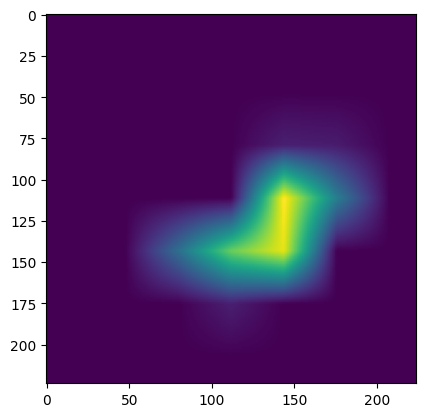

In [151]:
plt.imshow(np.squeeze(heatmap))

In [141]:
sum(iou_scores)/len(iou_scores)

np.float64(0.03336705107046943)